In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data

train = pd.read_csv('train_final.csv', index_col = 0)
train.head()

,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,diameter,wall,length,...,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8,Total_quantity,Total_weight
0,2,66,0,1,1,1,21.905933,6.35,0.71,137.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.018
1,2,66,0,2,1,2,12.341214,6.35,0.71,137.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.018
2,2,66,0,5,1,5,6.601826,6.35,0.71,137.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.018
3,2,66,0,10,1,10,4.687770,6.35,0.71,137.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.018
4,2,66,0,25,1,25,3.541561,6.35,0.71,137.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.018


In [3]:
train.columns

Index(['tube_assembly_id', 'supplier', 'annual_usage', 'min_order_quantity',
       'bracket_pricing', 'quantity', 'cost', 'diameter', 'wall', 'length',
       'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x',
       'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket', 'other',
       'year', 'month', 'dayofyear', 'dayofweek', 'day', 'component_id_1',
       'quantity_1', 'component_id_2', 'quantity_2', 'component_id_3',
       'quantity_3', 'component_id_4', 'quantity_4', 'component_id_5',
       'quantity_5', 'component_id_6', 'quantity_6', 'component_id_7',
       'quantity_7', 'component_id_8', 'quantity_8', 'Total_quantity',
       'Total_weight'],
      dtype='object')


## Feature scaling and normalisation

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
X = train.drop('cost', axis=1)
y = train.cost

# Log transform skewed features
col_list = ['annual_usage', 'min_order_quantity','quantity', 
            'diameter', 'wall', 'length','num_bends', 
            'bend_radius', 'num_boss', 'num_bracket', 'other',
            'year', 'month', 'dayofyear', 'dayofweek', 'day', 
            'component_id_1', 'quantity_1', 'component_id_2', 
            'quantity_2', 'component_id_3', 'quantity_3', 
            'component_id_4', 'quantity_4', 'component_id_5',
            'quantity_5', 'component_id_6', 'quantity_6', 
            'component_id_7','quantity_7', 'component_id_8', 
            'quantity_8', 'Total_quantity', 'Total_weight']
            
for col_name in col_list:
    X[col_name] = np.log1p(X[col_name])

y = np.log1p(y)

In [6]:
# Split train into train and validate sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Model Training

In [8]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error 

In [9]:
rfr = RandomForestRegressor(n_estimators=300, random_state=42)

rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_valid)

**Evaluation with Root Mean Squared Logarithmic Error (RMSLE)** 

If you want to join the Caterpillar competition, it was evaluated with RMSLE, which is calculated as

$$RMSLE = \sqrt{\\frac{1}{n} \\sum_{i=1}^n (\\log(p_i + 1) - \\log(a_i+1))^2 } \$$

where,
- $p_i$ is the predicted price
- $a_i$ is the actual price

In [10]:
# Define RMSLE function
def rmsle(yhat, y):
    '''
       We can import mean_squared_log_error (MSLE), but recall that 
       we have already log1p transformed y before we split the data
    '''
    return np.sqrt(mean_squared_error(yhat, y))

In [11]:
error = rmsle(y_pred_rfr, y_valid)
# Print the error:
print("RMSLE: %.4f" % error)

RMSLE: 0.2494


In [12]:
etr = ExtraTreesRegressor(n_estimators=300, random_state=42)

etr.fit(X_train, y_train)
y_pred_etr = etr.predict(X_valid)


error = rmsle(y_pred_etr, y_valid)
# Print the error:
print("RMSLE: %.4f" % error)

RMSLE: 0.2316


It seems the ExtraTreeRegressor performs much better than RandomForestRegressor

### Cross-validation

In [13]:
# Evaluate models using cross-validation
from sklearn.model_selection import cross_val_score

score_rfr = cross_val_score(rfr, X, y, scoring='neg_mean_squared_error', cv=5)

rmsle_score = np.sqrt(-score_rfr)

print("RMSLE:", rmsle_score)
print("Mean:", rmsle_score.mean())
print("Standard deviation:", rmsle_score.std())

RMSLE: [0.33642249 0.28195608 0.31687382 0.41183674 0.33616988]
Mean: 0.3366518008696751
Standard deviation: 0.042510821883734236


In [14]:
# Now, let's try the ExtraTreeRegressor
score_etr = cross_val_score(etr, X, y, scoring='neg_mean_squared_error', cv=5)

rmsle_score = np.sqrt(-score_etr)

print("RMSLE:", rmsle_score)
print("Mean:", rmsle_score.mean())
print("Standard deviation:", rmsle_score.std())

RMSLE: [0.29718307 0.26424793 0.30076046 0.39674188 0.33506201]
Mean: 0.31879907045528133
Standard deviation: 0.04496228241290504


With cross-validation, we can see that the ExtraTree indeed perform better (with smaller mean RMSLE error) than RandomForest regressor. Let's select this model for now and fine-tune it.

### Model Fine-tuning

In [15]:
"""Warning: It took extremely long time to run the following model"""

# from sklearn.model_selection import GridSearchCV

# params = {'n_estimators': [300, 600, 800, 1000],
#           'max_depth': [None, 4, 6, 8, 10, 15, 20],
#           'max_features': ['auto', 'sqrt', 'log2'],
#           'min_samples_leaf': [2, 4, 6, 8],
#           'min_samples_split': [2, 4, 6, 8],
#           'bootstrap': [True, False] }
    
# etr = ExtraTreesRegressor(random_state=42)

# grid_search = GridSearchCV(etr, param_grid=params, cv=5,
#                          scoring ='neg_mean_squared_error')

# grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse',
                                           max_depth=None, max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators='warn', n_jobs=None,
                                           oob_score=False, random_state=42,
                                           v...=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 4, 6, 8, 10, 15, 20],
       

In [16]:
# grid_search.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=2, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=1000,
                    n_jobs=None, oob_score=False, random_state=42, verbose=0,
                    warm_start=False)

In [17]:
# Copy the best parameters and make prediction on valid data.

xtra = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=2, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=1000,
                    n_jobs=None, oob_score=False, random_state=42, verbose=0,
                    warm_start=False)

xtra.fit(X_train, y_train)
y_pred_xtra = xtra.predict(X_valid)

error = rmsle(y_pred_xtra, y_valid)
# Print the error:
print("RMSLE: %.4f" % error)

RMSLE: 0.2404


With a bit of more time, and more CPU power, you could possibly get better parameters

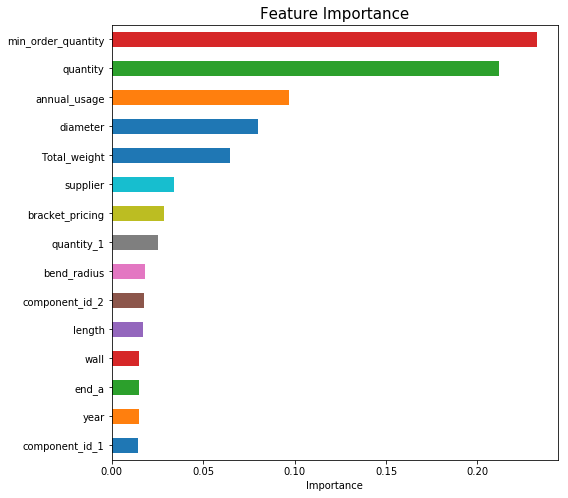

In [19]:
# Plot feature importance
feature_rank = pd.Series(xtra.feature_importances_, index=X_train.columns)

plt.figure(figsize=(8,8))
feature_rank.nlargest(15).sort_values(ascending = True).plot(kind='barh')
plt.xlabel('Importance')
plt.title('Feature Importance', fontsize =15);

## Model Predicting

Now, we will apply our trained model to make prediction on the test set.

We will need to load the data first, and then follow exactly the same steps to transform the test set as we did for the train set.
A better way to do this would have been to define functions and apply them to the test set.

**Note**: The order of columns in test set should be set identical to that of those in the train set

In [54]:
# Load test data
test = pd.read_csv('data/test_set.csv', parse_dates=[3])
tube = pd.read_csv("data/tube.csv")
bom = pd.read_csv("bom_final.csv", index_col=0)

In [55]:
test.head()

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25


In [56]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30235 entries, 0 to 30234
Data columns (total 8 columns):
id                    30235 non-null int64
tube_assembly_id      30235 non-null object
supplier              30235 non-null object
quote_date            30235 non-null datetime64[ns]
annual_usage          30235 non-null int64
min_order_quantity    30235 non-null int64
bracket_pricing       30235 non-null object
quantity              30235 non-null int64
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 1.8+ MB


In [57]:
test = pd.merge(test, tube, on ='tube_assembly_id')

In [58]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

test['bracket_pricing'] = le.fit_transform(test.bracket_pricing)
test['end_a_1x'] = le.fit_transform(test.end_a_1x)
test['end_a_2x'] = le.fit_transform(test.end_a_2x)
test['end_x_1x'] = le.fit_transform(test.end_x_1x)
test['end_x_2x'] = le.fit_transform(test.end_x_2x)

In [59]:
end_form = pd.read_csv('data/tube_end_form.csv')

In [60]:
# Lable encode 'forming' column to 0 or 1
end_form['forming'] = le.fit_transform(end_form.forming)

# Then, map 'forming' value onto 'end_a' and 'end_x' columns
test['end_a'] = test['end_a'].map(end_form.set_index('end_form_id')['forming']) 
test['end_x'] = test['end_x'].map(end_form.set_index('end_form_id')['forming'])

# Fill null value with 0, as no ends means no forming
test.end_a.fillna(0, inplace=True)
test.end_x.fillna(0, inplace=True)

In [61]:
test['year'] = test.quote_date.dt.year
test['month'] = test.quote_date.dt.month
test['dayofyear'] = test.quote_date.dt.dayofyear
test['dayofweek'] = test.quote_date.dt.dayofweek
test['day'] = test.quote_date.dt.day

In [62]:
# copy id for submission later on
ids = test.id 

# Drop useless features from test for analysis
test = test.drop(['id', 'quote_date'], axis = 1)

In [63]:
test = pd.merge(test, bom, on ='tube_assembly_id')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30235 entries, 0 to 30234
Data columns (total 44 columns):
tube_assembly_id      30235 non-null object
supplier              30235 non-null object
annual_usage          30235 non-null int64
min_order_quantity    30235 non-null int64
bracket_pricing       30235 non-null int32
quantity              30235 non-null int64
material_id           30009 non-null object
diameter              30235 non-null float64
wall                  30235 non-null float64
length                30235 non-null float64
num_bends             30235 non-null int64
bend_radius           30235 non-null float64
end_a_1x              30235 non-null int32
end_a_2x              30235 non-null int32
end_x_1x              30235 non-null int32
end_x_2x              30235 non-null int32
end_a                 30235 non-null float64
end_x                 30235 non-null float64
num_boss              30235 non-null int64
num_bracket           30235 non-null int64
other           

In [64]:
# Split tube_assembly_id into two seperate columns
tube_id = test['tube_assembly_id'].str.split("-", n=1, expand=True)
test['tube_assembly_id'] = tube_id[1].astype(int)

# Split supplier id into two seperate columns and assign the numbers only
supplier_id = test['supplier'].str.split("-", n=1, expand=True) 
test['supplier'] = supplier_id[1].astype(int)

test.head()

,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,material_id,diameter,wall,length,...,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8,Total_quantity,Total_weight
0,1,66,0,0,1,1,SP-0035,12.7,1.65,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.096
1,1,66,0,0,1,2,SP-0035,12.7,1.65,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.096
2,1,66,0,0,1,5,SP-0035,12.7,1.65,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.096
3,1,66,0,0,1,10,SP-0035,12.7,1.65,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.096
4,1,66,0,0,1,25,SP-0035,12.7,1.65,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.096


In [65]:
# Align min_order_quantity with 'quantity'
test['min_order_quantity'] = test['min_order_quantity'].where(
    test.min_order_quantity > test.quantity, test.quantity)

In [66]:
test.drop(columns=['material_id'], inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30235 entries, 0 to 30234
Data columns (total 43 columns):
tube_assembly_id      30235 non-null int32
supplier              30235 non-null int32
annual_usage          30235 non-null int64
min_order_quantity    30235 non-null int64
bracket_pricing       30235 non-null int32
quantity              30235 non-null int64
diameter              30235 non-null float64
wall                  30235 non-null float64
length                30235 non-null float64
num_bends             30235 non-null int64
bend_radius           30235 non-null float64
end_a_1x              30235 non-null int32
end_a_2x              30235 non-null int32
end_x_1x              30235 non-null int32
end_x_2x              30235 non-null int32
end_a                 30235 non-null float64
end_x                 30235 non-null float64
num_boss              30235 non-null int64
num_bracket           30235 non-null int64
other                 30235 non-null int64
year               

In [67]:
# Log transform skewed features in test set
col_list = ['annual_usage', 'min_order_quantity','quantity', 
            'diameter', 'wall', 'length','num_bends', 
            'bend_radius', 'num_boss', 'num_bracket', 'other',
            'year', 'month', 'dayofyear', 'dayofweek', 'day', 
            'component_id_1', 'quantity_1', 'component_id_2', 
            'quantity_2', 'component_id_3', 'quantity_3', 
            'component_id_4', 'quantity_4', 'component_id_5',
            'quantity_5', 'component_id_6', 'quantity_6', 
            'component_id_7','quantity_7', 'component_id_8', 
            'quantity_8', 'Total_quantity', 'Total_weight']
            
for col_name in col_list:
    test[col_name] = np.log1p(test[col_name])

In [68]:
# Save test to file
test.to_csv('test_final.csv')

In [69]:
# Make predictions

pred = np.expm1(xtra.predict(test))               # reverse transform prediction back to original scale

pred = pd.DataFrame({"id": ids, "cost": pred})
pred.to_csv('benchmark1.csv', index=False)         # save it to csv file for submission online

This model received a **Private score** (70% of test data): **0.26107** and a **Public score** (30% of test data): **0.26464**

## Conclusion

In this tutorial, we have used suppliers quotations from Caterpillar to predict its future suppliers pricing for tube assembly.
We have performed data loading, clearning, manipulation, and feature engineering/transformation. We have also trained different machine learning models including randomforest regression and extratree regression, and tried cross-validation and fine-tuned our final model with GridSearchCV. With the best estimator we obtained, we made predictions on the test set. 

Alghouth the socres are not too bad, to improve predictions, you could try to apply the followings,

 - Collect more data if you could for real-world problem (unlikely in this competition)
 - Perform better feature engineering/transforamtion
 - Train different models (e.g. Adaboost, bagging, etc.)
 - Search for optimal hyperparameters (e.g. GridsearchCV)
 
 

In [42]:
#import xgboost as xgb

# params = {"objective": "reg:linear", "eta": 0.02,
#           "min_child_weight": 6, "subsample": 0.7,
#           "colsample_bytree": 0.7, "scale_pos_weight": 0.8,
#           "silent": 1, "max_depth": 8, "max_delta_step": 2}

# dtrain = xgb.DMatrix(X, label=y)                     
# dtest =  xgb.DMatrix(test)

# num_rounds = 3000
# model = xgb.train(params, dtrain, num_rounds)
# preds = model.predict(dtest)

# preds = np.expm1(preds)
# preds = pd.DataFrame({"id": ids, "cost": preds})
# preds.to_csv('benchmarkXGB.csv', index=False)